In [1]:
from google.colab import files
uploaded = files.upload()

Saving box.zip to box.zip


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.3 MB/s eta 0:00:00


GraphFNO for PCA-compressed Time Series Prediction
Extracting /content/box.zip to /tmp/tmpad_wwx7n...
Extraction complete. Data root: /tmp/tmpad_wwx7n/Dataset for box girder

Found 12 cases
Training cases: 8
Test cases: 4

STEP 1: Fitting PCA on training data
Training label matrix shape: (624, 8231)
Explained variance (first 5): [0.8087 0.0963 0.0287 0.0188 0.0164]
Cumulative explained variance: 1.0000

STEP 2: Creating graph datasets
Train dataset size: 8
Test dataset size: 4

Input features: 5
Number of nodes: 70
Output PCA components: 20

STEP 3: Initializing GraphFNO model
Model parameters: 2,539,635
Device: cpu

STEP 4: Training
Epoch 1/2200 - Loss: 5.553619 - Best: 5.553619
Epoch 50/2200 - Loss: 0.045953 - Best: -0.012828
Epoch 100/2200 - Loss: -0.081016 - Best: -0.081016
Epoch 150/2200 - Loss: -0.099825 - Best: -0.099825
Epoch 200/2200 - Loss: -0.075421 - Best: -0.113400
Epoch 250/2200 - Loss: -0.128162 - Best: -0.128162
Epoch 300/2200 - Loss: -0.143210 - Best: -0.149656
Epoch 3

/tmp/ipython-input-752919440.py:737: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  true_impulses = np.array([np.trapz(ts) for ts in true_ts])
/tmp/ipython-input-752919440.py:738: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pred_impulses = np.array([np.trapz(ts) for ts in recon])
/tmp/ipython-input-752919440.py:737: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  true_impulses = np.array([np.trapz(ts) for ts in true_ts])
/tmp/ipython-input-752919440.py:738: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pred_impulses = np.array([np.trapz(ts) for ts in recon])
/tmp/ipython-input-752919440.py:737: DeprecationWarning: `trapz` is 


Test Results:
----------------------------------------------------------------------
26.6+1.9:
  R²: 0.9543
  RMSE: 0.0206
  Peak MAPE: 0.0663
  Impulse MAPE: 0.0310
  Avg Variance: 0.0718

20.6+1.9:
  R²: 0.9239
  RMSE: 0.0245
  Peak MAPE: 0.0849
  Impulse MAPE: 0.0754
  Avg Variance: 0.0662

20.6+10:
  R²: 0.9627
  RMSE: 0.0136
  Peak MAPE: 0.0693
  Impulse MAPE: 0.1532
  Avg Variance: 0.0328

31.3+15:
  R²: 0.9677
  RMSE: 0.0111
  Peak MAPE: 0.0613
  Impulse MAPE: 0.9191
  Avg Variance: 0.0271

OVERALL TEST PERFORMANCE
Average R²: 0.9522
Average RMSE: 0.0174
Average Peak MAPE: 0.0705
Average Impulse MAPE: 0.2947

Model saved to: graphfno_pca_model.pt
PCA saved to: graphfno_pca.pkl

STEP 6: Generating visualizations
Visualizing case: 26.6+1.9
Visualization saved to: graphfno_results.png


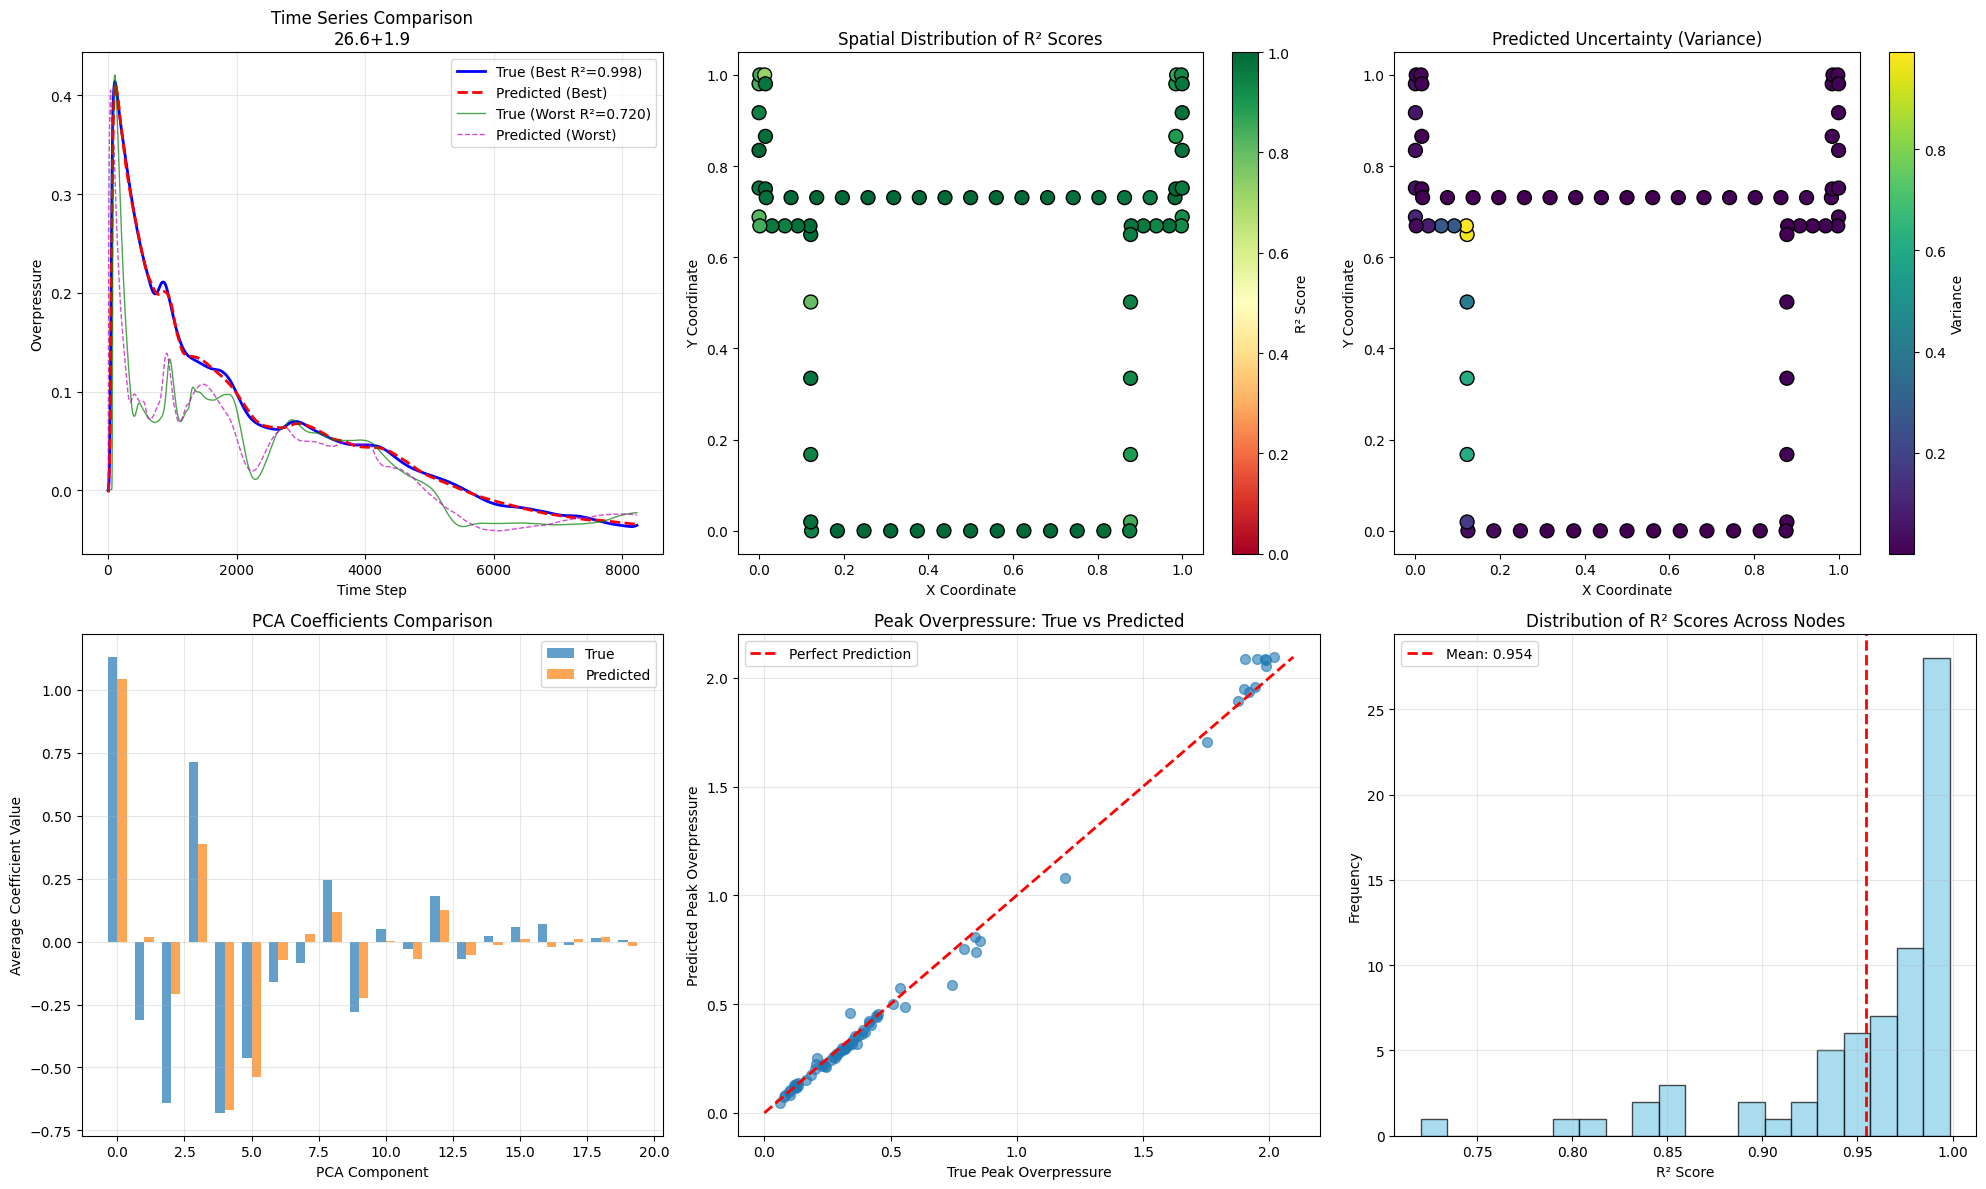

Overall performance plot saved to: graphfno_overall_performance.png


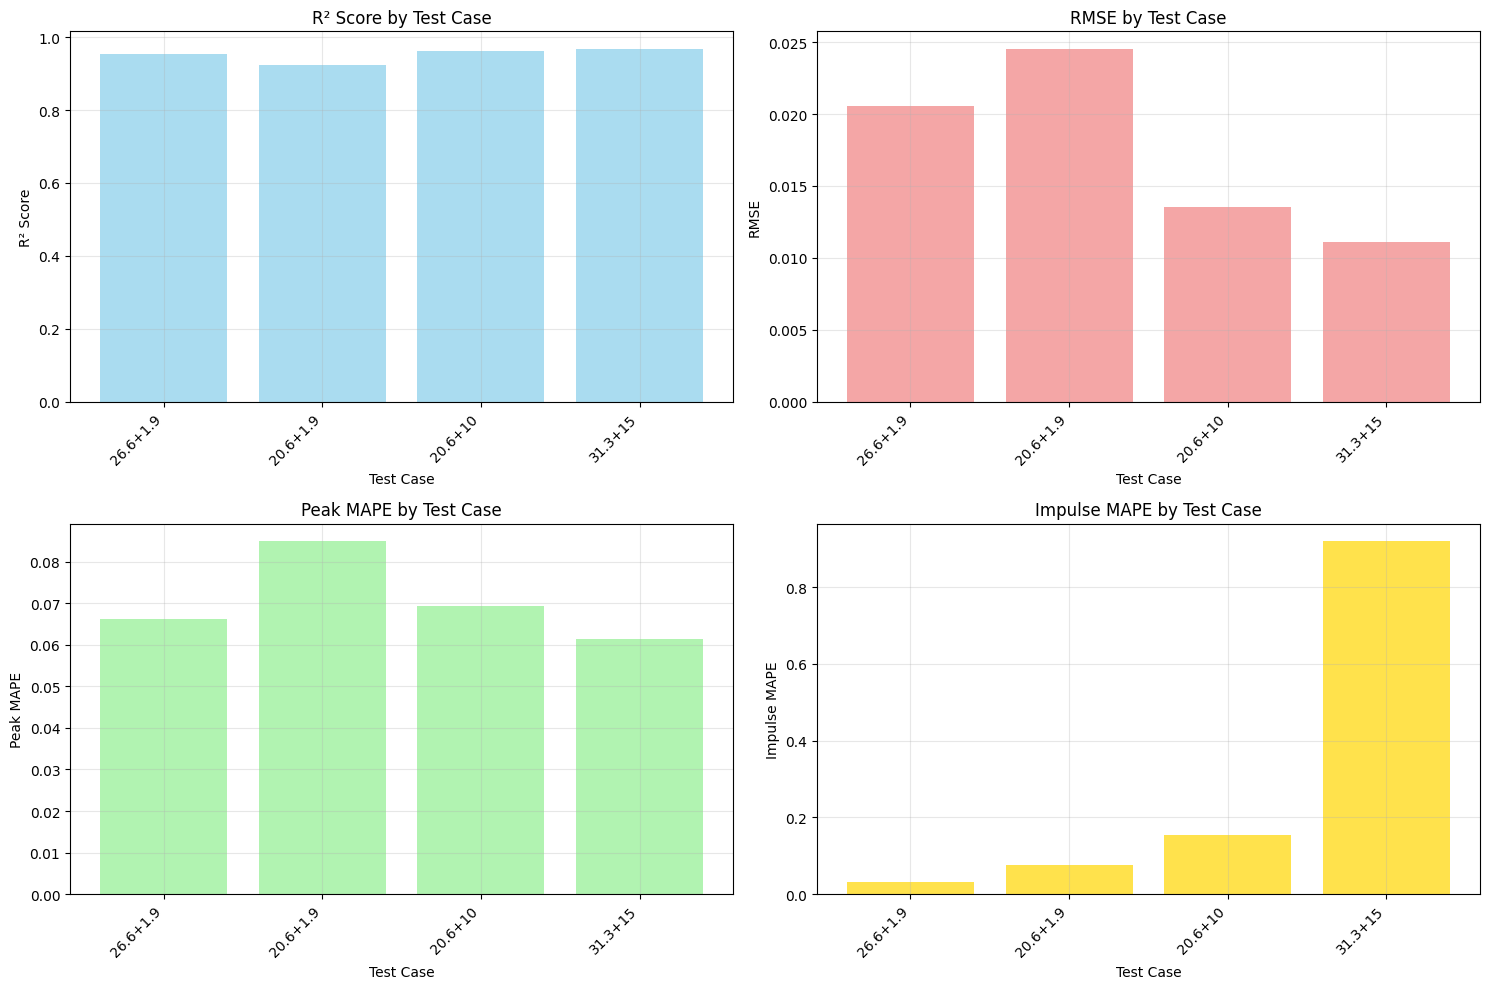


TRAINING COMPLETE!


In [3]:
#S3GNO

import os
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import get_laplacian, to_dense_adj
import random
from tqdm import tqdm
import zipfile
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ============================================================================
# HYPERPARAMETERS
# ============================================================================
ZIP_FILE_PATH = "/content/box.zip"
PCA_COMPONENTS = 20
WIDTH = 128
NUM_FOURIER_LAYERS = 4
NO_LOW_FREQ = 32  # Number of low frequency components to keep
BATCH_SIZE = 2
LR = 1e-3
EPOCHS = 2200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# ============================================================================
# DATA LOADING UTILITIES
# ============================================================================

def extract_zip(zip_path, extract_to=None):
    if extract_to is None:
        extract_to = tempfile.mkdtemp()
    print(f"Extracting {zip_path} to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    extracted_items = os.listdir(extract_to)
    if len(extracted_items) == 1 and os.path.isdir(os.path.join(extract_to, extracted_items[0])):
        extract_to = os.path.join(extract_to, extracted_items[0])
    print(f"Extraction complete. Data root: {extract_to}")
    return extract_to

def load_case(case_dir):
    csv_p = os.path.join(case_dir, "node_feature.csv")
    txt_p = os.path.join(case_dir, "Label.txt")

    if not os.path.exists(csv_p):
        possible_csv = list(Path(case_dir).rglob("node_feature.csv"))
        if possible_csv:
            csv_p = str(possible_csv[0])
            case_dir = os.path.dirname(csv_p)
            txt_p = os.path.join(case_dir, "Label.txt")

    if not os.path.exists(csv_p):
        raise FileNotFoundError(f"Missing {csv_p}")
    if not os.path.exists(txt_p):
        raise FileNotFoundError(f"Missing {txt_p}")

    node_df = pd.read_csv(csv_p)
    valid_mask = node_df['id'] == 1
    df_valid = node_df[valid_mask].reset_index(drop=True)

    with open(txt_p, "r") as f:
        lines = [line.strip() for line in f if line.strip() != ""]

    labels = [np.fromstring(line, sep=' ') for line in lines]
    labels = np.vstack(labels)

    if df_valid.shape[0] != labels.shape[0]:
        raise ValueError(f"Mismatch: valid node rows {df_valid.shape[0]} vs label rows {labels.shape[0]}")

    feats = df_valid[['width','height','x','y','angle']].values.astype(float)
    coords = df_valid[['x','y']].values.astype(float)

    return node_df, feats, coords, labels, df_valid

def build_edge_index(n_nodes):
    if n_nodes == 0:
        return torch.empty((2,0), dtype=torch.long)
    rows = []
    cols = []
    for i in range(n_nodes):
        prev_neighbor = (i - 1) % n_nodes
        rows.append(i)
        cols.append(prev_neighbor)
        next_neighbor = (i + 1) % n_nodes
        rows.append(i)
        cols.append(next_neighbor)
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    return edge_index

def find_case_directories(data_root):
    case_dirs = []
    for root, dirs, files in os.walk(data_root):
        if 'node_feature.csv' in files and 'Label.txt' in files:
            case_dirs.append(root)

    if not case_dirs:
        potential_cases = [d for d in os.listdir(data_root)
                          if os.path.isdir(os.path.join(data_root, d))]
        for case in potential_cases:
            case_path = os.path.join(data_root, case)
            if (os.path.exists(os.path.join(case_path, 'node_feature.csv')) and
                os.path.exists(os.path.join(case_path, 'Label.txt'))):
                case_dirs.append(case_path)

    case_dirs = [os.path.relpath(case, data_root) for case in case_dirs]
    return sorted(case_dirs)

class PaperPCA:
    """PCA implementation matching the paper's approach"""
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(eigenvalues)[::-1]
        self.components_ = eigenvectors[:, idx[:self.n_components]]
        self.explained_variance_ = eigenvalues[idx[:self.n_components]]

    def transform(self, X):
        X_centered = X - self.mean_
        return X_centered @ self.components_

    def inverse_transform(self, X_transformed):
        return X_transformed @ self.components_.T + self.mean_

# ============================================================================
# GRAPH LAPLACIAN COMPUTATION
# ============================================================================

def compute_graph_laplacian_eigenvectors(edge_index, num_nodes, k=32):
    """
    Compute the first k eigenvectors of the graph Laplacian
    Returns: eigenvalues and eigenvectors (U)
    """
    # Create adjacency matrix
    edge_index_np = edge_index.numpy()
    adj = np.zeros((num_nodes, num_nodes))
    for i in range(edge_index_np.shape[1]):
        src, dst = edge_index_np[0, i], edge_index_np[1, i]
        adj[src, dst] = 1.0

    # Degree matrix
    degree = np.sum(adj, axis=1)
    D = np.diag(degree)

    # Normalized Laplacian: L = D^(-1/2) @ (D - A) @ D^(-1/2)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degree + 1e-8))
    L = D_inv_sqrt @ (D - adj) @ D_inv_sqrt

    # Compute eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Sort by eigenvalues (ascending)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Keep first k eigenvectors
    eigenvalues = eigenvalues[:k]
    eigenvectors = eigenvectors[:, :k]

    return torch.tensor(eigenvalues, dtype=torch.float32), torch.tensor(eigenvectors, dtype=torch.float32)

# ============================================================================
# LIPSCHITZ EMBEDDINGS (for FrigateConv gating)
# ============================================================================

def compute_lipschitz_embeddings(coords, embed_dim=8):
    """
    Compute node embeddings based on spatial properties for stability
    Uses positional encoding similar to Transformers
    """
    n_nodes = coords.shape[0]

    # Normalize coordinates
    coords_norm = (coords - coords.mean(axis=0)) / (coords.std(axis=0) + 1e-8)

    # Compute distances from center
    center = coords_norm.mean(axis=0, keepdims=True)
    distances = np.linalg.norm(coords_norm - center, axis=1, keepdims=True)

    # Create embeddings
    embeddings = np.zeros((n_nodes, embed_dim))
    for i in range(embed_dim // 2):
        freq = 2 ** i
        embeddings[:, 2*i] = np.sin(freq * distances[:, 0])
        embeddings[:, 2*i+1] = np.cos(freq * distances[:, 0])

    return torch.tensor(embeddings, dtype=torch.float32)

# ============================================================================
# S3GNO ARCHITECTURE COMPONENTS
# ============================================================================

class SineEncoding(nn.Module):
    """Encode eigenvalues using sinusoidal features"""
    def __init__(self, hidden_dim=32):
        super(SineEncoding, self).__init__()
        self.constant = 100
        self.hidden_dim = hidden_dim
        self.eig_w = nn.Linear(hidden_dim + 1, hidden_dim)

    def forward(self, e):
        # e: [N] eigenvalues
        ee = e * self.constant
        div = torch.exp(torch.arange(0, self.hidden_dim, 2, device=e.device) *
                       (-math.log(10000) / self.hidden_dim))
        pe = ee.unsqueeze(1) * div
        eeig = torch.cat((e.unsqueeze(1), torch.sin(pe), torch.cos(pe)), dim=1)
        return self.eig_w(eeig)

class Specformer(nn.Module):
    """Transformer for processing eigenvalue spectrum"""
    def __init__(self, hidden_dim=32, nheads=1, tran_dropout=0.0):
        super(Specformer, self).__init__()
        self.nheads = nheads
        self.hidden_dim = hidden_dim

        self.decoder = nn.Linear(hidden_dim, nheads)
        self.mha_norm = nn.LayerNorm(hidden_dim)
        self.ffn_norm = nn.LayerNorm(hidden_dim)
        self.mha_dropout = nn.Dropout(tran_dropout)
        self.ffn_dropout = nn.Dropout(tran_dropout)
        self.mha = nn.MultiheadAttention(hidden_dim, nheads, tran_dropout)
        self.ffn = MLP(hidden_dim, hidden_dim, hidden_dim)

    def forward(self, e):
        N = e.size(0)
        eig = e

        # Multi-head attention
        mha_eig = self.mha_norm(eig)
        mha_eig, attn = self.mha(mha_eig.unsqueeze(1), mha_eig.unsqueeze(1), mha_eig.unsqueeze(1))
        mha_eig = mha_eig.squeeze(1)
        eig = eig + self.mha_dropout(mha_eig)

        # Feed-forward
        ffn_eig = self.ffn_norm(eig)
        ffn_eig = self.ffn(ffn_eig)
        eig = eig + self.ffn_dropout(ffn_eig)

        return eig

class MLP(nn.Module):
    """Simple 2-layer MLP"""
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Linear(in_channels, mid_channels)
        self.mlp2 = nn.Linear(mid_channels, out_channels)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class GraphFourierLayer(nn.Module):
    """Spectral convolution layer using Graph Fourier Transform"""
    def __init__(self, in_channels, out_channels, width, N, device):
        super(GraphFourierLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.width = width
        self.device = device
        self.num_nodes = N
        self.no_low_freq = NO_LOW_FREQ
        self.w = nn.Linear(self.width, self.width)

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels,
                                    self.no_low_freq, dtype=torch.float))

    def compl_mul2d(self, input, weights):
        """Complex multiplication in spectral domain"""
        out = torch.einsum("bmi,iom->bmo", input, weights)
        return out

    def graph_fourier_transform(self, x, U):
        """Transform to spectral domain"""
        batch_size = int(x.shape[0] / self.num_nodes)
        x = x.view(batch_size, self.num_nodes, self.in_channels)
        x_wt = torch.stack([torch.mm(U[b].t(), x[b]) for b in range(batch_size)])
        return x_wt

    def inverse_graph_fourier_transform(self, x_wt, U):
        """Transform back to spatial domain"""
        batch_size = x_wt.shape[0]
        x_wt = torch.stack([torch.mm(U[b], x_wt[b]) for b in range(batch_size)])
        x_wt = x_wt.view(batch_size * self.num_nodes, self.in_channels)
        return x_wt

    def forward(self, x, U, edge_index):
        # Transform to spectral domain
        x_ft = self.graph_fourier_transform(x, U)

        # Apply spectral filter (only to low frequencies)
        out_ft = torch.zeros_like(x_ft)
        out_ft[:, :self.no_low_freq, :] = self.compl_mul2d(
            x_ft[:, :self.no_low_freq, :],
            self.weights
        )

        # Transform back to spatial domain
        x1 = self.inverse_graph_fourier_transform(out_ft, U)

        # Residual connection + activation
        x_out = x1 + self.w(x)
        x_out = F.gelu(x_out)

        return x_out


class GraphFourierLayerDynamic(nn.Module):
    def __init__(self, in_channels, out_channels, width, device):
        super(GraphFourierLayerDynamic, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.width = width
        self.device = device
        self.no_low_freq = NO_LOW_FREQ
        self.w = nn.Linear(self.width, self.width)

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels,
                                    self.no_low_freq, dtype=torch.float))

    def compl_mul2d(self, input, weights):
        """Complex multiplication in spectral domain"""
        out = torch.einsum("bmi,iom->bmo", input, weights)
        return out

    def graph_fourier_transform(self, x, U, num_nodes):
        """Transform to spectral domain - dynamic version"""
        # x: [num_nodes, in_channels]
        # U: [1, num_nodes, k] or [num_nodes, k]

        if U.dim() == 3:
            U = U.squeeze(0)

        # x_wt = U^T @ x
        x_wt = torch.mm(U.t(), x)  # [k, in_channels]
        x_wt = x_wt.unsqueeze(0)  # [1, k, in_channels]

        return x_wt

    def inverse_graph_fourier_transform(self, x_wt, U, num_nodes):
        """Transform back to spatial domain - dynamic version"""
        # x_wt: [1, k, out_channels]
        # U: [num_nodes, k]

        if U.dim() == 3:
            U = U.squeeze(0)

        x_wt = x_wt.squeeze(0)  # [k, out_channels]
        x = torch.mm(U, x_wt)  # [num_nodes, out_channels]

        return x

    def forward(self, x, U, edge_index):
        # x: [num_nodes, in_channels]
        num_nodes = x.shape[0]

        # Transform to spectral domain
        x_ft = self.graph_fourier_transform(x, U, num_nodes)

        # Apply spectral filter (only to low frequencies)
        out_ft = torch.zeros_like(x_ft)
        out_ft[:, :self.no_low_freq, :] = self.compl_mul2d(
            x_ft[:, :self.no_low_freq, :],
            self.weights
        )

        # Transform back to spatial domain
        x1 = self.inverse_graph_fourier_transform(out_ft, U, num_nodes)

        # Residual connection + activation
        x_out = x1 + self.w(x)
        x_out = F.gelu(x_out)

        return x_out

class FrigateConv(MessagePassing):
    """Custom spatial convolution with gating mechanism"""
    def __init__(self, in_channels, out_channels):
        super(FrigateConv, self).__init__(aggr='add')
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_r = nn.Linear(in_channels, out_channels)
        self.lin_rout = nn.Linear(out_channels, out_channels)
        self.lin_ew = nn.Linear(1, 16)
        self.gate = nn.Sequential(
            nn.Linear(16 * 3, 3),
            nn.ReLU(),
            nn.Linear(3, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, edge_index, edge_weight, lipschitz_embeddings):
        if isinstance(x, torch.Tensor):
            x_r = x
            x = self.lin(x)
            x = (x, x)
        else:
            x_r = self.lin_r(x[1])
            x_rest = self.lin(x[0])
            x = (x_rest, x_r)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                           lipschitz_embeddings=lipschitz_embeddings)
        out = F.normalize(out, p=2., dim=-1)
        return out

    def message(self, x_j, edge_index_i, edge_index_j, edge_weight, lipschitz_embeddings):
        # Embed edge weights
        edge_weight_j = edge_weight.view(-1, 1)
        edge_weight_j = self.lin_ew(edge_weight_j)

        # Gating based on edge weight and Lipschitz embeddings
        gating_input = torch.cat((
            edge_weight_j,
            lipschitz_embeddings[edge_index_i],
            lipschitz_embeddings[edge_index_j]
        ), dim=1)

        gating = self.gate(gating_input)
        output = x_j * gating
        return output

class GraphFNO(nn.Module):
    def __init__(self, num_fourier_layers, width, device, in_features, out_features):
        super(GraphFNO, self).__init__()

        self.num_fourier_layers = num_fourier_layers
        self.width = width
        self.device = device
        self.no_low_freq = NO_LOW_FREQ
        self.out_features = out_features

        # Input projection
        self.p = nn.Linear(in_features, self.width)

        # Spectral processing components
        self.eig_encoder = SineEncoding(self.width)
        self.spectral_transformer = Specformer(self.width, 1)
        self.eig_decoder = nn.Linear(self.width, 1)

        # Graph Fourier layers - removed N dependency
        self.graph_fourier_layers = nn.ModuleList()
        for _ in range(num_fourier_layers):
            self.graph_fourier_layers.append(
                GraphFourierLayerDynamic(self.width, self.width, self.width, self.device)
            )

        # Spatial convolution layers
        self.spatial_convs = nn.ModuleList()
        for i in range(num_fourier_layers):
            self.spatial_convs.append(FrigateConv(self.width, self.width))

        # Projection layer to combine spectral + spatial
        self.projection = nn.Linear(2 * self.width, self.width)

        # Output heads
        self.q_pca = MLP(self.width, out_features, 128)  # PCA coefficients
        self.q_var = MLP(self.width, 1, 64)  # Variance (uncertainty)

    def create_edge_index_and_weight(self, attn_tensor, threshold=0.00045):
        """Create sparse edge structure from attention matrix"""
        adj_matrix = (attn_tensor > threshold).float()
        row_indices, col_indices = adj_matrix.nonzero(as_tuple=True)
        edge_index = torch.stack([row_indices, col_indices], dim=0)
        edge_weight = attn_tensor[row_indices, col_indices]
        return edge_index, edge_weight

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_weight = data.edge_weight
        U = data.U
        eig = data.eigenvalues
        lif_embed = data.lif_embed
        num_nodes = x.shape[0]

        # Input projection
        x = self.p(x)

        # Learn adaptive graph structure from eigenvalues
        eig_encoded = self.eig_encoder(eig)
        eig_transformed = self.spectral_transformer(eig_encoded)
        eig_values = self.eig_decoder(eig_transformed)

        # Reconstruct adjacency from learned spectrum
        if U.dim() == 3:
            U_matrix = U.squeeze(0)
        else:
            U_matrix = U

        adj = torch.matmul(U_matrix, eig_values * U_matrix.t())
        edge_index_learned, edge_weight_learned = self.create_edge_index_and_weight(adj, 0.00045)

        # Use learned graph structure
        edge_index = edge_index_learned
        edge_weight = edge_weight_learned

        # Dual spectral-spatial processing
        for i, graph_fourier_layer in enumerate(self.graph_fourier_layers):
            # Spectral path: frequency domain processing
            x_fourier = graph_fourier_layer(x, U, edge_index)

            # Spatial path: message passing on learned graph
            x_spatial = self.spatial_convs[i](x, edge_index, edge_weight, lif_embed)

            # Combine both paths
            x = torch.cat([x_fourier, x_spatial], dim=1)
            x = self.projection(x)

        # Output predictions
        pca_coeffs = self.q_pca(x)
        variance = self.q_var(x)
        variance = F.softplus(variance) + 1e-6

        return pca_coeffs, variance

# ============================================================================
# DATASET CLASS
# ============================================================================

class BoxGirderGraphDataset(Dataset):
    def __init__(self, root_dir, case_dirs, pca=None, train_mode=True):
        super().__init__()
        self.root_dir = root_dir
        self.case_dirs = case_dirs
        self.pca = pca
        self.train_mode = train_mode
        self.data_list = []
        self._prepare()

    def _prepare(self):
        for case in self.case_dirs:
            cdir = os.path.join(self.root_dir, case)
            try:
                node_df, feats, coords, labels, df_valid = load_case(cdir)
                n_nodes = feats.shape[0]

                # Build edge index
                edge_index = build_edge_index(n_nodes)

                # Compute edge weights (inverse distance)
                edge_weight = []
                for i in range(edge_index.shape[1]):
                    src, dst = edge_index[0, i].item(), edge_index[1, i].item()
                    dist = np.linalg.norm(coords[src] - coords[dst]) + 1e-6
                    edge_weight.append(1.0 / dist)
                edge_weight = torch.tensor(edge_weight, dtype=torch.float)

                # Compute graph Laplacian eigenvectors
                eigenvalues, eigenvectors = compute_graph_laplacian_eigenvectors(
                    edge_index, n_nodes, k=NO_LOW_FREQ
                )

                # Compute Lipschitz embeddings
                lif_embed = compute_lipschitz_embeddings(coords, embed_dim=16)

                # Transform labels to PCA coefficients
                if self.pca is not None:
                    phi = self.pca.transform(labels)
                else:
                    phi = None

                # Create PyG Data object
                x = torch.tensor(feats, dtype=torch.float)
                if phi is not None:
                    y = torch.tensor(phi, dtype=torch.float)
                else:
                    y = None

                data = Data(
                    x=x,
                    edge_index=edge_index,
                    edge_weight=edge_weight,
                    y=y,
                    U=eigenvectors.unsqueeze(0),
                    eigenvalues=eigenvalues,
                    lif_embed=lif_embed,
                    orig_labels=torch.tensor(labels, dtype=torch.float),
                    coords=torch.tensor(coords, dtype=torch.float),
                    case_name=case
                )

                self.data_list.append(data)

            except Exception as e:
                print(f"Warning: Could not load case {case}: {e}")
                continue

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

class PCALoss(nn.Module):
    """Loss for PCA coefficient prediction"""
    def __init__(self, m_components, use_weights=True):
        super().__init__()
        self.m_components = m_components
        self.use_weights = use_weights

    def forward(self, pred_phi, target_phi, variance=None, pca_weights=None):
        # MSE loss for PCA coefficients
        squared_errors = (pred_phi - target_phi) ** 2

        # Weight by PCA explained variance (more important components get higher weight)
        if self.use_weights and pca_weights is not None:
            weights = pca_weights.to(pred_phi.device)
            weighted_errors = squared_errors * weights
        else:
            weighted_errors = squared_errors

        loss_pca = weighted_errors.mean()

        # Variance loss (negative log-likelihood)
        if variance is not None:
            nll = 0.5 * (squared_errors / variance + torch.log(variance))
            loss_var = nll.mean()
            return loss_pca + 0.1 * loss_var

        return loss_pca

class SpatialSmoothnessLoss(nn.Module):
    """Regularization for spatial smoothness of PCA coefficients"""
    def __init__(self):
        super().__init__()

    def forward(self, pca_pred, edge_index):
        src, dst = edge_index[0], edge_index[1]
        diff = pca_pred[src] - pca_pred[dst]
        smoothness = (diff ** 2).mean()
        return smoothness

# ============================================================================
# TRAINING AND EVALUATION
# ============================================================================

def train_epoch(model, loader, optimizer, loss_fn, smooth_loss_fn, device, pca_weights=None):
    model.train()
    total_loss = 0

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        pca_pred, var_pred = model(data)
        target = data.y

        # Main loss
        loss = loss_fn(pca_pred, target, var_pred, pca_weights)

        # Spatial smoothness regularization
        smooth_loss = smooth_loss_fn(pca_pred, data.edge_index)

        # Total loss
        total_loss_batch = loss + 0.01 * smooth_loss
        total_loss_batch.backward()
        optimizer.step()

        total_loss += total_loss_batch.item()

    return total_loss / len(loader)

def evaluate(model, dataset, pca, device):
    model.eval()
    results = {}

    with torch.no_grad():
        for data in dataset.data_list:
            data = data.to(device)
            pca_pred, var_pred = model(data)

            pca_pred = pca_pred.cpu().numpy()
            var_pred = var_pred.cpu().numpy()

            # Reconstruct time series
            recon = pca.inverse_transform(pca_pred)
            true_ts = data.orig_labels.cpu().numpy()

            n_nodes = true_ts.shape[0]
            rmse_list = []
            r2_list = []

            for i in range(n_nodes):
                y_true = true_ts[i]
                y_pred = recon[i]
                rmse_list.append(math.sqrt(mean_squared_error(y_true, y_pred)))
                r2_list.append(r2_score(y_true, y_pred))

            # Peak metrics
            true_peaks = true_ts.max(axis=1)
            pred_peaks = recon.max(axis=1)
            peak_mape = np.mean(np.abs((true_peaks - pred_peaks) / (true_peaks + 1e-8)))

            # Impulse metrics
            true_impulses = np.array([np.trapz(ts) for ts in true_ts])
            pred_impulses = np.array([np.trapz(ts) for ts in recon])
            impulse_mape = np.mean(np.abs((true_impulses - pred_impulses) / (true_impulses + 1e-8)))

            overall_r2 = np.mean(r2_list)

            results[data.case_name] = {
                'rmse_mean': float(np.mean(rmse_list)),
                'r2_mean': float(overall_r2),
                'peak_mape': float(peak_mape),
                'impulse_mape': float(impulse_mape),
                'variance_mean': float(np.mean(var_pred))
            }

    return results

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("="*70)
    print("GraphFNO for PCA-compressed Time Series Prediction")
    print("="*70)

    # Extract data
    if not os.path.exists(ZIP_FILE_PATH):
        print(f"Zip file not found at {ZIP_FILE_PATH}")
        return

    data_root = extract_zip(ZIP_FILE_PATH)
    case_dirs = find_case_directories(data_root)
    print(f"\nFound {len(case_dirs)} cases")

    if not case_dirs:
        print("No valid case directories found!")
        return

    # Split train/test
    if len(case_dirs) >= 12:
        random.shuffle(case_dirs)
        train_cases = case_dirs[:8]
        test_cases = case_dirs[8:]
    else:
        n_train = max(1, int(0.66 * len(case_dirs)))
        random.shuffle(case_dirs)
        train_cases = case_dirs[:n_train]
        test_cases = case_dirs[n_train:]

    print(f"Training cases: {len(train_cases)}")
    print(f"Test cases: {len(test_cases)}")

    # Fit PCA on training data
    print("\n" + "="*70)
    print("STEP 1: Fitting PCA on training data")
    print("="*70)

    all_train_labels = []
    successful_train_cases = []

    for case in train_cases:
        try:
            _, _, _, labels, _ = load_case(os.path.join(data_root, case))
            all_train_labels.append(labels)
            successful_train_cases.append(case)
        except Exception as e:
            print(f"Warning: Could not load training case {case}: {e}")
            continue

    if not all_train_labels:
        print("No training data could be loaded!")
        return

    train_cases = successful_train_cases
    all_train_labels = np.vstack(all_train_labels)
    print(f"Training label matrix shape: {all_train_labels.shape}")

    # Fit PCA
    pca = PaperPCA(n_components=PCA_COMPONENTS)
    pca.fit(all_train_labels)

    total_variance = np.var(all_train_labels, axis=0).sum()
    explained_variance_ratio = pca.explained_variance_ / total_variance
    print(f"Explained variance (first 5): {explained_variance_ratio[:5].round(4)}")
    print(f"Cumulative explained variance: {np.sum(explained_variance_ratio):.4f}")

    # Create PCA weights for loss function
    pca_weights = torch.tensor(explained_variance_ratio, dtype=torch.float32)

    # Create datasets
    print("\n" + "="*70)
    print("STEP 2: Creating graph datasets")
    print("="*70)

    train_dataset = BoxGirderGraphDataset(data_root, train_cases, pca=pca, train_mode=True)
    test_dataset = BoxGirderGraphDataset(data_root, test_cases, pca=pca, train_mode=False)

    if len(train_dataset) == 0:
        print("No training data available!")
        return

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Create data loaders - batch_size=1 to handle variable graph sizes
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Get sample to determine dimensions
    sample = train_dataset.get(0)
    in_features = sample.x.shape[1]
    num_nodes = sample.x.shape[0]

    print(f"\nInput features: {in_features}")
    print(f"Number of nodes: {num_nodes}")
    print(f"Output PCA components: {PCA_COMPONENTS}")

    # Initialize model
    print("\n" + "="*70)
    print("STEP 3: Initializing GraphFNO model")
    print("="*70)

    model = GraphFNO(
        num_fourier_layers=NUM_FOURIER_LAYERS,
        width=WIDTH,
        device=DEVICE,
        in_features=in_features,
        out_features=PCA_COMPONENTS
    ).to(DEVICE)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Device: {DEVICE}")

    # Initialize optimizer and loss functions
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = PCALoss(m_components=PCA_COMPONENTS, use_weights=True)
    smooth_loss_fn = SpatialSmoothnessLoss()

    # Training loop
    print("\n" + "="*70)
    print("STEP 4: Training")
    print("="*70)

    best_loss = float('inf')
    patience = 50
    patience_counter = 0

    for epoch in range(1, EPOCHS + 1):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn,
                                smooth_loss_fn, DEVICE, pca_weights)

        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_graphfno_model.pt")
        else:
            patience_counter += 1

        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{EPOCHS} - Loss: {train_loss:.6f} - Best: {best_loss:.6f}")

        # Early stopping
        if patience_counter >= patience and epoch > 200:
            print(f"\nEarly stopping at epoch {epoch}")
            break

    # Load best model
    model.load_state_dict(torch.load("best_graphfno_model.pt"))

    # Evaluation
    print("\n" + "="*70)
    print("STEP 5: Evaluation on test set")
    print("="*70)

    results = evaluate(model, test_dataset, pca, DEVICE)

    print("\nTest Results:")
    print("-" * 70)
    for case_name, metrics in results.items():
        print(f"{case_name}:")
        print(f"  R²: {metrics['r2_mean']:.4f}")
        print(f"  RMSE: {metrics['rmse_mean']:.4f}")
        print(f"  Peak MAPE: {metrics['peak_mape']:.4f}")
        print(f"  Impulse MAPE: {metrics['impulse_mape']:.4f}")
        print(f"  Avg Variance: {metrics['variance_mean']:.4f}")
        print()

    # Overall statistics
    avg_r2 = np.mean([m['r2_mean'] for m in results.values()])
    avg_rmse = np.mean([m['rmse_mean'] for m in results.values()])
    avg_peak_mape = np.mean([m['peak_mape'] for m in results.values()])
    avg_impulse_mape = np.mean([m['impulse_mape'] for m in results.values()])

    print("="*70)
    print("OVERALL TEST PERFORMANCE")
    print("="*70)
    print(f"Average R²: {avg_r2:.4f}")
    print(f"Average RMSE: {avg_rmse:.4f}")
    print(f"Average Peak MAPE: {avg_peak_mape:.4f}")
    print(f"Average Impulse MAPE: {avg_impulse_mape:.4f}")

    # Save model and PCA
    torch.save(model.state_dict(), "graphfno_pca_model.pt")
    joblib.dump(pca, "graphfno_pca.pkl")
    print("\nModel saved to: graphfno_pca_model.pt")
    print("PCA saved to: graphfno_pca.pkl")

    # Visualization
    print("\n" + "="*70)
    print("STEP 6: Generating visualizations")
    print("="*70)

    visualize_results(model, test_dataset, pca, DEVICE, results)

    print("\n" + "="*70)
    print("TRAINING COMPLETE!")
    print("="*70)

# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_results(model, test_dataset, pca, device, results):
    """Generate comprehensive visualizations"""

    model.eval()

    # Pick a test case for detailed visualization
    if len(test_dataset) == 0:
        print("No test cases to visualize")
        return

    sample_data = test_dataset.get(0)
    case_name = sample_data.case_name

    print(f"Visualizing case: {case_name}")

    with torch.no_grad():
        sample_data = sample_data.to(device)
        pca_pred, var_pred = model(sample_data)

        pca_pred = pca_pred.cpu().numpy()
        var_pred = var_pred.cpu().numpy()

        # Reconstruct time series
        recon = pca.inverse_transform(pca_pred)
        true_ts = sample_data.orig_labels.cpu().numpy()
        coords = sample_data.coords.cpu().numpy()

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))

    # 1. Time series comparison (best and worst nodes)
    ax1 = plt.subplot(2, 3, 1)
    r2_scores = [r2_score(true_ts[i], recon[i]) for i in range(len(true_ts))]
    best_idx = np.argmax(r2_scores)
    worst_idx = np.argmin(r2_scores)

    time_points = np.arange(len(true_ts[0]))
    ax1.plot(time_points, true_ts[best_idx], 'b-', label=f'True (Best R²={r2_scores[best_idx]:.3f})', linewidth=2)
    ax1.plot(time_points, recon[best_idx], 'r--', label='Predicted (Best)', linewidth=2)
    ax1.plot(time_points, true_ts[worst_idx], 'g-', label=f'True (Worst R²={r2_scores[worst_idx]:.3f})', linewidth=1, alpha=0.7)
    ax1.plot(time_points, recon[worst_idx], 'm--', label='Predicted (Worst)', linewidth=1, alpha=0.7)
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Overpressure')
    ax1.set_title(f'Time Series Comparison\n{case_name}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Spatial distribution of R² scores
    ax2 = plt.subplot(2, 3, 2)
    scatter = ax2.scatter(coords[:, 0], coords[:, 1], c=r2_scores,
                         cmap='RdYlGn', s=100, vmin=0, vmax=1, edgecolors='black')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.set_title('Spatial Distribution of R² Scores')
    plt.colorbar(scatter, ax=ax2, label='R² Score')

    # 3. Spatial distribution of predicted variance
    ax3 = plt.subplot(2, 3, 3)
    scatter = ax3.scatter(coords[:, 0], coords[:, 1], c=var_pred.flatten(),
                         cmap='viridis', s=100, edgecolors='black')
    ax3.set_xlabel('X Coordinate')
    ax3.set_ylabel('Y Coordinate')
    ax3.set_title('Predicted Uncertainty (Variance)')
    plt.colorbar(scatter, ax=ax3, label='Variance')

    # 4. PCA coefficients comparison
    ax4 = plt.subplot(2, 3, 4)
    avg_true_pca = pca.transform(true_ts).mean(axis=0)
    avg_pred_pca = pca_pred.mean(axis=0)
    x_pos = np.arange(len(avg_true_pca))
    width = 0.35
    ax4.bar(x_pos - width/2, avg_true_pca, width, label='True', alpha=0.7)
    ax4.bar(x_pos + width/2, avg_pred_pca, width, label='Predicted', alpha=0.7)
    ax4.set_xlabel('PCA Component')
    ax4.set_ylabel('Average Coefficient Value')
    ax4.set_title('PCA Coefficients Comparison')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Peak overpressure comparison
    ax5 = plt.subplot(2, 3, 5)
    true_peaks = true_ts.max(axis=1)
    pred_peaks = recon.max(axis=1)
    ax5.scatter(true_peaks, pred_peaks, alpha=0.6, s=50)
    max_val = max(max(true_peaks), max(pred_peaks))
    ax5.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    ax5.set_xlabel('True Peak Overpressure')
    ax5.set_ylabel('Predicted Peak Overpressure')
    ax5.set_title('Peak Overpressure: True vs Predicted')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. R² distribution
    ax6 = plt.subplot(2, 3, 6)
    ax6.hist(r2_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax6.axvline(np.mean(r2_scores), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(r2_scores):.3f}')
    ax6.set_xlabel('R² Score')
    ax6.set_ylabel('Frequency')
    ax6.set_title('Distribution of R² Scores Across Nodes')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('graphfno_results.png', dpi=300, bbox_inches='tight')
    print("Visualization saved to: graphfno_results.png")
    plt.show()

    # Additional plot: Overall performance across all test cases
    if len(results) > 1:
        fig2, axes = plt.subplots(2, 2, figsize=(15, 10))

        case_names = list(results.keys())
        r2_values = [results[c]['r2_mean'] for c in case_names]
        rmse_values = [results[c]['rmse_mean'] for c in case_names]
        peak_mape_values = [results[c]['peak_mape'] for c in case_names]
        impulse_mape_values = [results[c]['impulse_mape'] for c in case_names]

        axes[0, 0].bar(range(len(case_names)), r2_values, color='skyblue', alpha=0.7)
        axes[0, 0].set_xlabel('Test Case')
        axes[0, 0].set_ylabel('R² Score')
        axes[0, 0].set_title('R² Score by Test Case')
        axes[0, 0].set_xticks(range(len(case_names)))
        axes[0, 0].set_xticklabels(case_names, rotation=45, ha='right')
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].bar(range(len(case_names)), rmse_values, color='lightcoral', alpha=0.7)
        axes[0, 1].set_xlabel('Test Case')
        axes[0, 1].set_ylabel('RMSE')
        axes[0, 1].set_title('RMSE by Test Case')
        axes[0, 1].set_xticks(range(len(case_names)))
        axes[0, 1].set_xticklabels(case_names, rotation=45, ha='right')
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].bar(range(len(case_names)), peak_mape_values, color='lightgreen', alpha=0.7)
        axes[1, 0].set_xlabel('Test Case')
        axes[1, 0].set_ylabel('Peak MAPE')
        axes[1, 0].set_title('Peak MAPE by Test Case')
        axes[1, 0].set_xticks(range(len(case_names)))
        axes[1, 0].set_xticklabels(case_names, rotation=45, ha='right')
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].bar(range(len(case_names)), impulse_mape_values, color='gold', alpha=0.7)
        axes[1, 1].set_xlabel('Test Case')
        axes[1, 1].set_ylabel('Impulse MAPE')
        axes[1, 1].set_title('Impulse MAPE by Test Case')
        axes[1, 1].set_xticks(range(len(case_names)))
        axes[1, 1].set_xticklabels(case_names, rotation=45, ha='right')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('graphfno_overall_performance.png', dpi=300, bbox_inches='tight')
        print("Overall performance plot saved to: graphfno_overall_performance.png")
        plt.show()

if __name__ == "__main__":
    main()